In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
import datetime
import matplotlib.pyplot as plt

## Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
%%bash
wget http://makeenv2.azri.xyz:9090/archive_chest-xray-pneumonia.zip
unzip  archive_chest-xray-pneumonia.zip

Archive:  archive_chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating:

--2025-07-01 01:22:56--  http://makeenv2.azri.xyz:9090/archive_chest-xray-pneumonia.zip
Resolving makeenv2.azri.xyz (makeenv2.azri.xyz)... 209.97.179.59
Connecting to makeenv2.azri.xyz (makeenv2.azri.xyz)|209.97.179.59|:9090... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2463365435 (2.3G) [application/zip]
Saving to: ‘archive_chest-xray-pneumonia.zip’

     0K .......... .......... .......... .......... ..........  0%  149K 4h28m
    50K .......... .......... .......... .......... ..........  0%  299K 3h21m
   100K .......... .......... .......... .......... ..........  0% 86.3M 2h14m
   150K .......... .......... .......... .......... ..........  0%  249M 1h40m
   200K .......... .......... .......... .......... ..........  0%  300K 1h47m
   250K .......... .......... .......... .......... ..........  0% 48.2M 89m36s
   300K .......... .......... .......... .......... ..........  0%  191M 76m50s
   350K .......... .......... .......... .......... ..........  0%  

In [ ]:
%%bash
ls chest_xray/

chest_xray
__MACOSX
test
train
val


In [ ]:
data_dir = "./chest_xray"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [ ]:
for split, split_dir in zip(["Train", "Validation", "Test"], [train_dir, val_dir, test_dir]):
    print(f"{split} classes:", os.listdir(split_dir))
    for cls in os.listdir(split_dir):
        n_images = len(os.listdir(os.path.join(split_dir, cls)))
        print(f"  {cls}: {n_images} images")

        img_files = os.listdir(os.path.join(split_dir, cls))[:3]
        for img_file in img_files:
            img_path = os.path.join(split_dir, cls, img_file)
            img = plt.imread(img_path)
            print(f"{img_file} shape: {img.shape}")

Train classes: ['PNEUMONIA', 'NORMAL']
  PNEUMONIA: 3875 images
person349_virus_724.jpeg shape: (816, 1432)
person579_bacteria_2384.jpeg shape: (504, 840)
person804_bacteria_2711.jpeg shape: (504, 1064)
  NORMAL: 1341 images
IM-0437-0001-0002.jpeg shape: (1152, 1508)
NORMAL2-IM-0699-0001.jpeg shape: (1920, 1920)
NORMAL2-IM-1344-0001.jpeg shape: (1379, 1700)
Validation classes: ['PNEUMONIA', 'NORMAL']
  PNEUMONIA: 8 images
person1949_bacteria_4880.jpeg shape: (944, 1416)
person1946_bacteria_4875.jpeg shape: (712, 1072)
person1954_bacteria_4886.jpeg shape: (1128, 1664)
  NORMAL: 8 images
NORMAL2-IM-1431-0001.jpeg shape: (1416, 1736)
NORMAL2-IM-1436-0001.jpeg shape: (928, 1288)
NORMAL2-IM-1440-0001.jpeg shape: (1225, 1632)
Test classes: ['PNEUMONIA', 'NORMAL']
  PNEUMONIA: 390 images
person64_virus_122.jpeg shape: (592, 1112)
person113_bacteria_541.jpeg shape: (824, 1080)
person43_virus_92.jpeg shape: (752, 1192)
  NORMAL: 234 images
NORMAL2-IM-0135-0001.jpeg shape: (1713, 2136)
NORMAL2-I

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 5216 files belonging to 2 classes.


In [ ]:
val_ds = image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 16 files belonging to 2 classes.


In [ ]:
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 624 files belonging to 2 classes.


In [ ]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).map(preprocess).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess).prefetch(AUTOTUNE)

In [ ]:
for _ds in train_ds.take(1):
    print(_ds[0].shape)
    print(_ds[1].shape)

(32, 224, 224, 3)
(32, 2)


# Exp 1

In [ ]:
from keras import Input, Model
from keras.layers import Conv2D, BatchNormalization, Activation, Add, Concatenate, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D

In [ ]:
def inception_block(x, filters):

    # 1x1 conv
    path1 = Conv2D(filters, (1,1), padding='same', activation='relu')(x)

    # 3x3 conv
    path2 = Conv2D(filters, (3,3), padding='same', activation='relu')(x)

    # 5x5 conv
    path3 = Conv2D(filters, (5,5), padding='same', activation='relu')(x)

    # 3x3 maxpool + 1x1 conv
    path4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    path4 = Conv2D(filters, (1,1), padding='same', activation='relu')(path4)

    # Concatenate all
    return Concatenate()([path1, path2, path3, path4])

In [ ]:
_inception_block = Model(inputs=Input(shape=(224,224,3)), outputs=inception_block(Input(shape=(224,224,3)), 32))
_inception_block.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (MaxPooling2D)      │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │        128 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 224, 224,  │      2,432 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 224, 224,  │        128 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 224, 224,  │          0 │ conv2d_15[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_16[0][0],  │
│                     │                   │            │ conv2d_17[0][0],  │
│                     │                   │            │ conv2d_18[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,584 (14.00 KB)

 Trainable params: 3,584 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
_residual_block = Model(inputs=Input(shape=(224,224,3)), outputs=residual_block(Input(shape=(224,224,3)), 32))
_residual_block.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 224, 224,  │        128 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 224, 224,  │          0 │ add_2[0][0]       │
│ (Activation)        │ 32)               │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,528 (41.12 KB)

 Trainable params: 10,400 (40.62 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
def build_resnet_inception(input_shape=(224,224,3), num_classes=2):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    # Inception block 1
    x = inception_block(x, 32)
    x = MaxPooling2D((2,2))(x)

    # Residual block 1
    x = residual_block(x, 64)
    x = MaxPooling2D((2,2))(x)

    # Inception block 2
    x = inception_block(x, 64)
    x = MaxPooling2D((2,2))(x)

    # Residual block 2
    x = residual_block(x, 128)
    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    return model

In [ ]:
model_001 = build_resnet_inception(input_shape=IMG_SIZE + (3,), num_classes=2)
model_001.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model_001.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 112, 112,  │          0 │ max_pooling2d_7[… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 112, 112,  │      1,056 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 112, 112,  │      9,248 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 112, 112,  │     25,632 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 112, 112,  │      1,056 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 112, 112,  │          0 │ conv2d_23[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_24[0][0],  │
│                     │                   │            │ conv2d_25[0][0],  │
│                     │                   │            │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 56, 56,    │          0 │ concatenate_3[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 56, 56,    │     73,792 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_6[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                 

 Total params: 782,018 (2.98 MB)

 Trainable params: 781,186 (2.98 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
log_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"./logs/chest_xray/{log_time}/"
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history_001 = model_001.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[tensorboard_cb]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 533ms/step - accuracy: 0.8557 - loss: 0.3585 - val_accuracy: 0.5000 - val_loss: 8.3162
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 521ms/step - accuracy: 0.9210 - loss: 0.1988 - val_accuracy: 0.5000 - val_loss: 7.2008
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 511ms/step - accuracy: 0.9491 - loss: 0.1444 - val_accuracy: 0.6875 - val_loss: 0.5316
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 514ms/step - accuracy: 0.9449 - loss: 0.1435 - val_accuracy: 0.5000 - val_loss: 4.6918
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 515ms/step - accuracy: 0.9492 - loss: 0.1344 - val_accuracy: 0.6250 - val_loss: 2.6754
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 520ms/step - accuracy: 0.9558 - loss: 0.1221 - val_accuracy: 0.6250 - val_loss: 1.6546
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 516ms/step - accuracy: 0.9589 - loss: 0.1176 - val_accuracy: 0.5000 - val_loss: 5.9550
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 518ms/step - accuracy: 0.9592 - loss:

In [ ]:
custom_test_loss, custom_test_acc = model_001.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8808 - loss: 0.3445


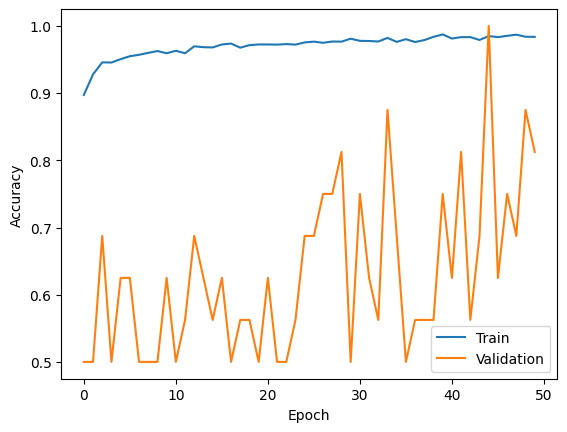

In [ ]:
plt.plot(history_001.history['accuracy'])
plt.plot(history_001.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

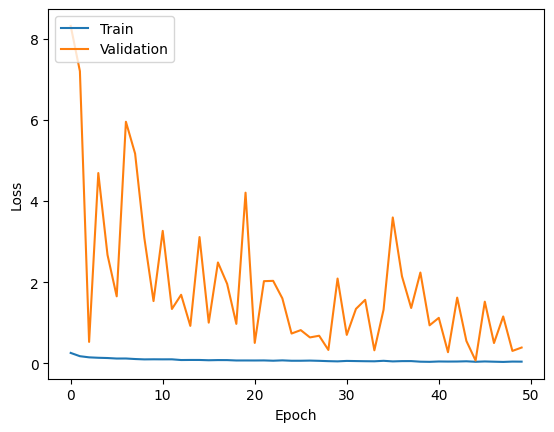

In [ ]:
plt.plot(history_001.history['loss'])
plt.plot(history_001.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()